# Phoneme Classifier Results
### Author: Cathal Ó Faoláin
### 16:57, 29/08/2024

The goal of this work is to understand how we can use predicted IHC potentials, such as those predicted by WavIHC, introduced in the paper "WaveNet-based approximation of a cochlear filtering and hair cell transduction model".  Feature encoders designed to use these predicted IHC potentials are evaluated against other state-of-the-art feature encoders in order to understand how discriminating they are, and over a range of different Signal-to-Noise Ratios (SNRs).

This notebook describes the networks we are evaluating and their results. We have 9 feature encoders:

- Contrastive Predictive Coding (CPC) 
- Wav2vec2.0
- Autoregressive Predictive Coding (APC)
- IHC CPC
- IHC CPC 80
- IHC Wav2vec2
- IHC Wav2vec2 80
- IHC Extract
- IHC Extract 512

This should grant us with a much better understanding of our models, their limitations and advantages.

The first three feature encoders, CPC, Wav2vec2.0 and APC are based on the designs used in each of the papers. Any context encoders that tries to model longer-term dependencies have been removed - so no transformers or Recurrent Neural Networks (RNN). This is to allow for us to evaluate how discriminating the features themselves are. 

IHC CPC and Wav2vec2 are adapted feature encoders that take predicted IHC potentials as input rather than the signal alone. Each is inspired by their namesake models.

In [1]:
import torch
from torch import nn
import librosa
import time
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from torch.utils.data import DataLoader, Dataset, IterableDataset
import torchaudio
import pandas as pd
import numpy as np
import seaborn as sns
import time
import sys
import yaml
import math
import pickle
import scipy.signal as signal
from dataclasses import dataclass, field
from typing import List, Tuple
import torch.nn.functional as F
import IPython.display as ipd
import matplotlib.pyplot as plt

In [2]:
sys.path.append('./IHCApproxNH/')
from classes import WaveNet
from utils import utils
from Encoders import FeatureEncoders 
from TIMIT_utils import TIMIT_utils
from Train_TestFunctions import TrainEvalFunctions
!pip install openpyxl


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: pip install --upgrade pip


## Set Global Learning Settings

In [3]:
EPOCHS=100
learning_rate=0.01

## Model Parameter Descriptor

In [4]:
model_dict, trainable_dict=TrainEvalFunctions.all_models_parameters()

params_df=pd.DataFrame({ 'Total Parameters':model_dict, 'Trainable Parameters':trainable_dict})

params_df['Frozen Parameters']=params_df["Total Parameters"]-params_df["Trainable Parameters"]

params_df.sort_values(by=['Total Parameters'], inplace=True)

params_df

> Initialising model: Wav2Vec2.0
> Initialising model: CPC
> Initialising model: MelSimple
> Initialising model: MelSimple_MLP
> Initialising model: Whisper
> Initialising model: Whisper_80
> Initialising model: Wav2Vec2.0_80
> Initialising model: CPC_80
> Initialising model: IHC_CPC
> Initialising model: IHC_CPC_80
> Initialising model: IHC_Wav2Vec2_80
> Initialising model: IHC_Wav2Vec2
> Initialising model: IHC_Extract
> Initialising model: IHC_Extract_512
> Initialising model: IHC_Extract_2.0
> Initialising model: IHC_Extract_3.0
> Initialising model: SIG_Extract
> Initialising model: SIG_Extract_512
> Initialising model: SIG_Extract_2.0
> Initialising model: SIG_Extract_3.0


,Total Parameters,Trainable Parameters,Frozen Parameters
MelSimple,3159,3159,0
SIG_Extract_3.0,12714,12714,0
Whisper_80,41719,41719,0
Wav2vec2_80,106519,106519,0
SIG_Extract_2.0,113834,113834,0
CPC_80,131959,131959,0
SIG_Extract,137184,137184,0
MelSimple_MLP,586791,586791,0
Whisper,930343,930343,0
IHC_Extract_3.0,3541870,12714,3529156


## Visualisation of Inputs
To make it clear the difference between the inputs visually, here we will create a visulisation showing: the signal, the Mel Spectrogram and the predicted IHCs. These will be created for the same soundbite and placed on a 3-row graph.

## Results Dataframe
Here we will get all of our results - for each of the k-folds, for each of the noise types, etc and join them in one very large dataframe. We can then manipulate this dataframe to get the results we need to present.

In [5]:
def model_check(x):
    designation_type={"wav2vec2_80":"W2V_small", "wav2vec2": "W2V",  "cpc_80": "CPC_small", "cpc": "CPC", "mel": "APC", "extract_2.0": "AFE2", "extract_512" : "AFE_large", "extract" : "AFE", "extract_3.0":"AFE3", "whisper": "WHIS",
                      "whisper_80": "WHIS_small"}
    model_types= ["wav2vec2_80", "wav2vec2", "cpc_80","cpc", "mel", "extract_2.0", "extract_512", "extract", "whisper"]
    for model in model_types:
        if model in x.lower():
            return designation_type[model]

    return "None"

In [6]:
#Get the original models and IHC models in one dataframe
model_input=["original", "IHC"] 
complete_df=pd.DataFrame()

original_list=[ "MelSimple_MLP", "MelSimple", "Wav2vec2", "Wav2vec2_80", "CPC_80", "CPC",  "SIG_Extract", "SIG_Extract_512", "SIG_Extract_2.0", "Whisper", "Whisper_80", "SIG_Extract_3.0"]
IHC_list=["IHC_Cpc", "IHC_Wav2vec2", "IHC_Extract_512", "IHC_Extract", "IHC_Cpc_80", "IHC_Wav2vec2_80",   "IHC_Extract_2.0", "IHC_Extract_3.0"]

#Noise variables
SNRs=[30, 25, 20, 15, 10, 5, 0, -5, -10]
noise_types=['White', 'air_conditioner', 'dog_bark', 'street_music', 'children_playing']

#Get the clean Results first, then the Noisy then the k-fold stability equivalents of each
locations=["Results/Clean/", "Results/Noisy/", "Results/k-Fold Stability/", "Results/Noisy/k-Fold Stability/"]

#This holds the model designation classifications
designations={"MelSimple":"MEL_APC_small","MelSimple_MLP": "MEL_APC", "CPC" : "SIG_CPC",\
              "IHC_Cpc": "IHC_CPC", "CPC_80": "SIG_CPC_small", "IHC_Cpc_80": "IHC_CPC_small", "Wav2vec2": "SIG_W2V","IHC_Wav2vec2": "IHC_W2V",\
"Wav2vec2_80":"SIG_W2V_small", "IHC_Wav2vec2_80": "IHC_W2V_small", "SIG_Extract": "SIG_AFE", "IHC_Extract":"IHC_AFE",\
              "SIG_Extract_512": "SIG_AFE_large", "IHC_Extract_512": "IHC_AFE_large", "SIG_Extract_2.0":"SIG_AFE2", "IHC_Extract_2.0":"IHC_AFE2", 
             "Whisper": "MEL_WHIS", "Whisper_80": "MEL_WHIS_small", "SIG_Extract_3.0": "SIG_AFE3", "IHC_Extract_3.0": "IHC_AFE3"}

#Loop through the model locations
for location in locations:
    print("===========================================")
    print("Adding results from location: %s" %location)
    
    location_count=0
    
    #And the original vs IHC models
    for type in model_input:
        if "Noisy" not in location:
            with open("{}{}_models.pkl".format(location, type), 'rb') as f:
                filename="{}{}_models.pkl".format(location, type)
                loaded_test=pickle.load(f)

            #Split the dataframe into Model and kFold
            df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
            df=df.reset_index()
            if "k-Fold" in location:
                df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
            else:
                df['Model']=[x[0] for x in df['index'].str.split('-')]
                df["kFold"]="Full"

            #Assert that only the models we expected are where we expected, and all are there
            if type=="original":
                for model in df["Model"].unique():
                    assert(model in original_list)
                    
                assert(len(df["Model"].unique()))
            else:
                for model in df["Model"].unique():
                    assert(model in IHC_list)
                
                assert(len(df["Model"].unique()))
                    
            if type=="original":
                df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else ("Mel" if "Whisp" in x else "SIG"))
            elif type=="IHC":
                df["Input Type"]= df["Model"].apply(lambda x: "SIG" if "SIG" in x else "IHC")
            df["Model Type"]=df["Model"].apply(model_check)
            df.drop(columns=["index"], inplace=True)
            df['SNR']="Clean"
            df['Noise Type']="Clean"
            df["PER"]=1-df["Accuracy"]
            df["Designation"]=df["Model"].apply(lambda x: designations[x])
            df.reset_index()
            
            complete_df=pd.concat([complete_df, df], ignore_index=True)
            print(" > Added %d records from %s" %(len(df), filename))
            
            location_count=location_count+len(df)
        else:
            
            for noise in noise_types:
                ##############################
                print(" Getting results for noise types :: %s" %noise)
                #Get all the snrs that were tested 
                for snr in SNRs:
                    with open('{}{}/{}/{}_models.pkl'.format(location, noise, snr, type), 'rb') as f:
                        filename='{}{}/{}/{}_models.pkl'.format(location, noise, snr, type)
                        loaded_test = pickle.load(f)                

                    #Split the dataframe into Model and kFold
                    df=pd.DataFrame.from_dict(loaded_test, orient='index', columns=['Accuracy'])
                    df=df.reset_index()
                    if "k-Fold" in location:
                        df[['Model', 'kFold']]=[(x[0], x[2]) for x in df['index'].str.split('-')]
                    else:
                        df['Model']=[x[0] for x in df['index'].str.split('-')]
                        df["kFold"]="Full"

                    #Assert that only the models we expected are where we expected
                    if type=="original":
                        for model in df["Model"].unique():
                            assert(model in original_list)
                        assert(len(df["Model"].unique()))
                    else:
                        for model in df["Model"].unique():
                            assert(model in IHC_list)
                            
                        #assert(len(df["Model"].unique()))
                    
                    if type=="original":
                        df["Input Type"]= df["Model"].apply(lambda x: "Mel" if "Mel" in x else ("Mel" if "Whisp" in x else "SIG"))
                    elif type=="IHC":
                        df["Input Type"]= df["Model"].apply(lambda x: "SIG" if "SIG" in x else "IHC")
                    df["Model Type"]=df["Model"].apply(model_check)
                    df.drop(columns=["index"], inplace=True)
                    df['SNR']=snr
                    df['Noise Type']=noise
                    df["PER"]=1-df["Accuracy"]
                    df["Designation"]=df["Model"].apply(lambda x: designations[x])
                    df.reset_index()
                        
                    #Concatenate this loaded test to other dataframes
                    complete_df=pd.concat([complete_df, df], ignore_index=True)
                    print("   > Added %d records from %s" %(len(df), filename))
                    location_count=location_count+len(df)

        print("==> Total of %d records found in location %s" %(location_count, location))
                
    ###################################

print(" ")
print(" ")
print("*********************************")
assert(len(complete_df)==5520)
print("Found records for %d tests" %(len(complete_df)))
print("*********************************")

complete_df

Adding results from location: Results/Clean/
 > Added 12 records from Results/Clean/original_models.pkl
==> Total of 12 records found in location Results/Clean/
 > Added 8 records from Results/Clean/IHC_models.pkl
==> Total of 20 records found in location Results/Clean/
Adding results from location: Results/Noisy/
 Getting results for noise types :: White
   > Added 12 records from Results/Noisy/White/30/original_models.pkl
   > Added 12 records from Results/Noisy/White/25/original_models.pkl
   > Added 12 records from Results/Noisy/White/20/original_models.pkl
   > Added 12 records from Results/Noisy/White/15/original_models.pkl
   > Added 12 records from Results/Noisy/White/10/original_models.pkl
   > Added 12 records from Results/Noisy/White/5/original_models.pkl
   > Added 12 records from Results/Noisy/White/0/original_models.pkl
   > Added 12 records from Results/Noisy/White/-5/original_models.pkl
   > Added 12 records from Results/Noisy/White/-10/original_models.pkl
 Getting resu

,Accuracy,Model,kFold,Input Type,Model Type,SNR,Noise Type,PER,Designation
0,0.564848,MelSimple_MLP,Full,Mel,APC,Clean,Clean,0.435152,MEL_APC
1,0.462800,MelSimple,Full,Mel,APC,Clean,Clean,0.537200,MEL_APC_small
2,0.574851,Wav2vec2,Full,SIG,W2V,Clean,Clean,0.425149,SIG_W2V
3,0.597252,Wav2vec2_80,Full,SIG,W2V_small,Clean,Clean,0.402748,SIG_W2V_small
4,0.602305,CPC_80,Full,SIG,CPC_small,Clean,Clean,0.397695,SIG_CPC_small
...,...,...,...,...,...,...,...,...,...
5515,0.097333,IHC_Extract_3.0,1,IHC,AFE,-10,children_playing,0.902667,IHC_AFE3
5516,0.089135,IHC_Extract_3.0,2,IHC,AFE,-10,children_playing,0.910865,IHC_AFE3
5517,0.083004,IHC_Extract_3.0,3,IHC,AFE,-10,children_playing,0.916996,IHC_AFE3
5518,0.079930,IHC_Extract_3.0,4,IHC,AFE,-10,children_playing,0.920070,IHC_AFE3


### Adding a Clean SNR for every noise type
Each noise type has no corresponding clean value. This rectifies this by adding the closest corresponding clean value for each noise type.

In [7]:
SNRs=["Clean", 30, 25, 20, 15, 10, 5, 0, -5, -10]
noise_types=['White', 'air_conditioner', 'dog_bark', 'street_music', 'children_playing']

print(len(complete_df))
count=0

for noise in noise_types:
    #The values need to match for model, kfold, input type, model type, and designation

    designations=complete_df["Designation"].unique()
    for designation in designations:
        
        kfolds=complete_df["kFold"].unique()
        for kfold in kfolds:
            #There should be one corresponding row 
            filtered_row=complete_df.loc[(complete_df["Noise Type"]=="Clean")  & (complete_df["kFold"]==kfold) & (complete_df["Designation"]==designation)]
            
            assert(len(filtered_row)==1)
            
            df2 = pd.DataFrame([[filtered_row.iloc[0]['Accuracy'],filtered_row.iloc[0]['Model'],kfold, filtered_row.iloc[0]['Input Type'], filtered_row.iloc[0]['Model Type'], \
                                 'Clean', noise, filtered_row.iloc[0]['PER'], designation]], columns=['Accuracy','Model','kFold', 'Input Type', 'Model Type', 'SNR', 'Noise Type', 'PER', 'Designation'])
            complete_df = pd.concat([df2, complete_df])
            
            count+=1

complete_df.drop_duplicates(inplace=True)
complete_df.dropna(inplace=True)

#Set the dataframe dtypes
complete_df = complete_df.astype(dtype= {'Accuracy':float,'Model':str,'kFold':'category', 'Input Type':str, 'Model Type':str, 'SNR':'category', 'Noise Type':str, 'PER':float, 'Designation':str})

#assert(count==600)
#assert(len(complete_df) == 6120)

print("Updating the dataframe to add a clean SNR for every noise type, assigning from clean values with matching designation and kfold")
print(" > Added %d rows to dataframe" %count)
print("==> Printing clean SNRs from the complete dataframe:")
complete_df[complete_df["SNR"]=="Clean"]

5520
Updating the dataframe to add a clean SNR for every noise type, assigning from clean values with matching designation and kfold
 > Added 600 rows to dataframe
==> Printing clean SNRs from the complete dataframe:


,Accuracy,Model,kFold,Input Type,Model Type,SNR,Noise Type,PER,Designation
0,0.550083,IHC_Extract_3.0,Full,IHC,AFE,Clean,children_playing,0.449917,IHC_AFE3
0,0.520454,IHC_Extract_3.0,1,IHC,AFE,Clean,children_playing,0.479546,IHC_AFE3
0,0.536638,IHC_Extract_3.0,2,IHC,AFE,Clean,children_playing,0.463362,IHC_AFE3
0,0.550460,IHC_Extract_3.0,3,IHC,AFE,Clean,children_playing,0.449540,IHC_AFE3
0,0.539748,IHC_Extract_3.0,4,IHC,AFE,Clean,children_playing,0.460252,IHC_AFE3
...,...,...,...,...,...,...,...,...,...
1015,0.520454,IHC_Extract_3.0,1,IHC,AFE,Clean,Clean,0.479546,IHC_AFE3
1016,0.536638,IHC_Extract_3.0,2,IHC,AFE,Clean,Clean,0.463362,IHC_AFE3
1017,0.550460,IHC_Extract_3.0,3,IHC,AFE,Clean,Clean,0.449540,IHC_AFE3
1018,0.539748,IHC_Extract_3.0,4,IHC,AFE,Clean,Clean,0.460252,IHC_AFE3


In [8]:
complete_df[complete_df["Model"]=="Whisper"]

,Accuracy,Model,kFold,Input Type,Model Type,SNR,Noise Type,PER,Designation
0,0.644102,Whisper,Full,Mel,WHIS,Clean,children_playing,0.355898,MEL_WHIS
0,0.633044,Whisper,1,Mel,WHIS,Clean,children_playing,0.366956,MEL_WHIS
0,0.635117,Whisper,2,Mel,WHIS,Clean,children_playing,0.364883,MEL_WHIS
0,0.637465,Whisper,3,Mel,WHIS,Clean,children_playing,0.362535,MEL_WHIS
0,0.635461,Whisper,4,Mel,WHIS,Clean,children_playing,0.364539,MEL_WHIS
...,...,...,...,...,...,...,...,...,...
3705,0.049163,Whisper,1,Mel,WHIS,-10,children_playing,0.950837,MEL_WHIS
3706,0.054534,Whisper,2,Mel,WHIS,-10,children_playing,0.945466,MEL_WHIS
3707,0.061647,Whisper,3,Mel,WHIS,-10,children_playing,0.938353,MEL_WHIS
3708,0.067100,Whisper,4,Mel,WHIS,-10,children_playing,0.932900,MEL_WHIS


## Does using IHCs improve Phoneme Recognition Performance in Noisy Environments?
We shall begin our exploration into the effects of using IHCs as alternatives to traditional inputs such as signal or Mel Spectrograms inputs by exploring the effect of using IHCs instead of the signal. Fig 1. shows the average effect of using IHCs instead of the signal with the same model type, across our given SNR range of 30dB to -10dB, for our 5 noise types. This is calculated by getting the average difference between .

In [9]:
def IHC_noise_PER(intervals=["Clean", 10, -10]):
    ###################################
    #Get the range of different model performance for each designation
    models=complete_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=complete_df[["Designation", "SNR", "Model Type"]].groupby(["Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=complete_df[["Designation", "SNR", "Input Type"]].groupby(["Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()

    #Assert that mean_PER has all the rows it should have
    assert(len(mean_PER)==len(models)*len(complete_df["SNR"].unique()))
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}
    markers={"SIG": "^", "Mel": "o", "IHC": "D"}

    fig, (ax)=plt.subplots(ncols=3, figsize=(16, 9))

    #We only want the models in the order, so take a subset of mean_PER
    types=complete_df["Model Type"].unique()
    order=['APC', 'WHIS', 'CPC', 'W2V', 'AFE', 'AFE2', 'AFE3']
    designated=['MEL_APC', 'MEL_WHIS', 'SIG_CPC', 'IHC_CPC', 'SIG_W2V', 'IHC_W2V', 'SIG_AFE', 'IHC_AFE', 'SIG_AFE2', 'SIG_AFE3' ,'IHC_AFE2', 'IHC_AFE3']
    mean_PER=mean_PER[mean_PER["Model Type"].isin(order)]
    mean_PER=mean_PER[mean_PER["Designation"].isin(designated)]
    
    models_df=complete_df[complete_df["Designation"].isin(designated)]
    
    differences={}
    #Plot each snr
    for ii, snr in enumerate(intervals):
        #Get the subset at the SNR value
        #Get the max difference between input sizes of the same PER
        y_size=0.0
        for i, n in enumerate(complete_df["SNR"].unique()):
            subcheck=complete_df[complete_df["SNR"]==n]
            y_now=max(subcheck["PER"]) - min(subcheck["PER"])+0.02
            if i==0:
                y_size=y_now
            elif y_now > y_size:
                y_size=y_now
        print(y_size)

        subset=complete_df[complete_df["SNR"]==snr]
        sub_mean=mean_PER[mean_PER["SNR"]==snr]
        #print(subset)
        inputs=["Mel", "SIG", "IHC"]
        
        for input in inputs:
            sub_PER=sub_mean[sub_mean["Input Type"]==input]
            
            #ax[ii].scatter(mean_PER["Designation"], mean_PER["PER"], c=line_colour[means["Input Type"].ilo c[0]], label=input, s=90, marker='_')
            #ax[ii].scatter(sub_PER["Designation"], sub_PER["PER"],c=line_colour[sub_PER["Input Type"].iloc[0]], label=input, s=150, marker=markers[sub_PER["Input Type"].iloc[0]], alpha=0.65)#, label=labels)
            #ax[ii].errorbar(sub_PER["Designation"], sub_PER["PER"], yerr=sub_PER["std"], c=line_colour[sub_PER["Input Type"].iloc[0]], fmt='o', alpha=0.3)

            if input=="SIG":
                sig_models=sub_PER["PER"].to_numpy()

        sub_df=models_df[models_df["SNR"]==snr]
        sns.boxplot(x="Designation", y="PER", hue="Input Type", order=["MEL_APC", "MEL_WHIS", "SIG_CPC", "SIG_W2V", "SIG_AFE", "SIG_AFE2", "SIG_AFE3", "IHC_CPC", "IHC_W2V", "IHC_AFE", "IHC_AFE2", "IHC_AFE3"], width=0.4, notch=True, palette=colours, data=sub_df, ax=ax[ii])
        
        #IHC_models=sub_PER["PER"].to_numpy()
        #print(np.subtract(sig_models, IHC_models))
        #print("At SNR %s, the average difference in performance is %f. \n" %(snr, np.average(np.subtract(sig_models, IHC_models))*100))
        
        
        #ax[ii].fill_between(sub_PER["SNR"], sub_PER["Lower Range"], sub_PER["Upper Range"], color=colours[input], alpha=0.5)
        #ax[ii].set_ylim(0.3, 1)
        ax[ii].legend(fontsize=18)
        if(snr == "Clean"):
            ax[ii].set_title("Clean Signal", fontsize=26)
        else:
            ax[ii].set_title("%s dB SNR " %snr, fontsize=26)
        ax[ii].set_ylabel("Phoneme Error Rate (PER)", fontsize=24)
        ax[ii].set_xlabel("Model Designation", fontsize=20)
        ax[ii].tick_params(axis='x',  labelcolor="dimgray", rotation=90, labelsize=20)
        ax[ii].tick_params(axis='y', labelcolor="dimgray", labelsize=20)
        
        
        #ax[ii].set_xticklabels(ax[ii].get_xticks(), rotation=60, fontsize=18)
#ax[ii].invert_xaxis()
        #Plot what happens if you simply predict the main phoneme type every time
            

    #fig.suptitle("Phoneme Recognition in Averaged Noise", fontsize=30)

    fig.tight_layout()

    plt.savefig("Graphs/PER_Averaged_Noise_boxplot.pdf".format(noise), format="pdf", bbox_inches="tight")

    return mean_PER

0.41073455861438024


/tmp/ipykernel_3158806/1900753860.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_PER=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).mean()
/tmp/ipykernel_3158806/1900753860.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_PER["Upper Range"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(1)["PER"]
/tmp/ipykernel_3158806/1900753860.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

0.41073455861438024
0.41073455861438024


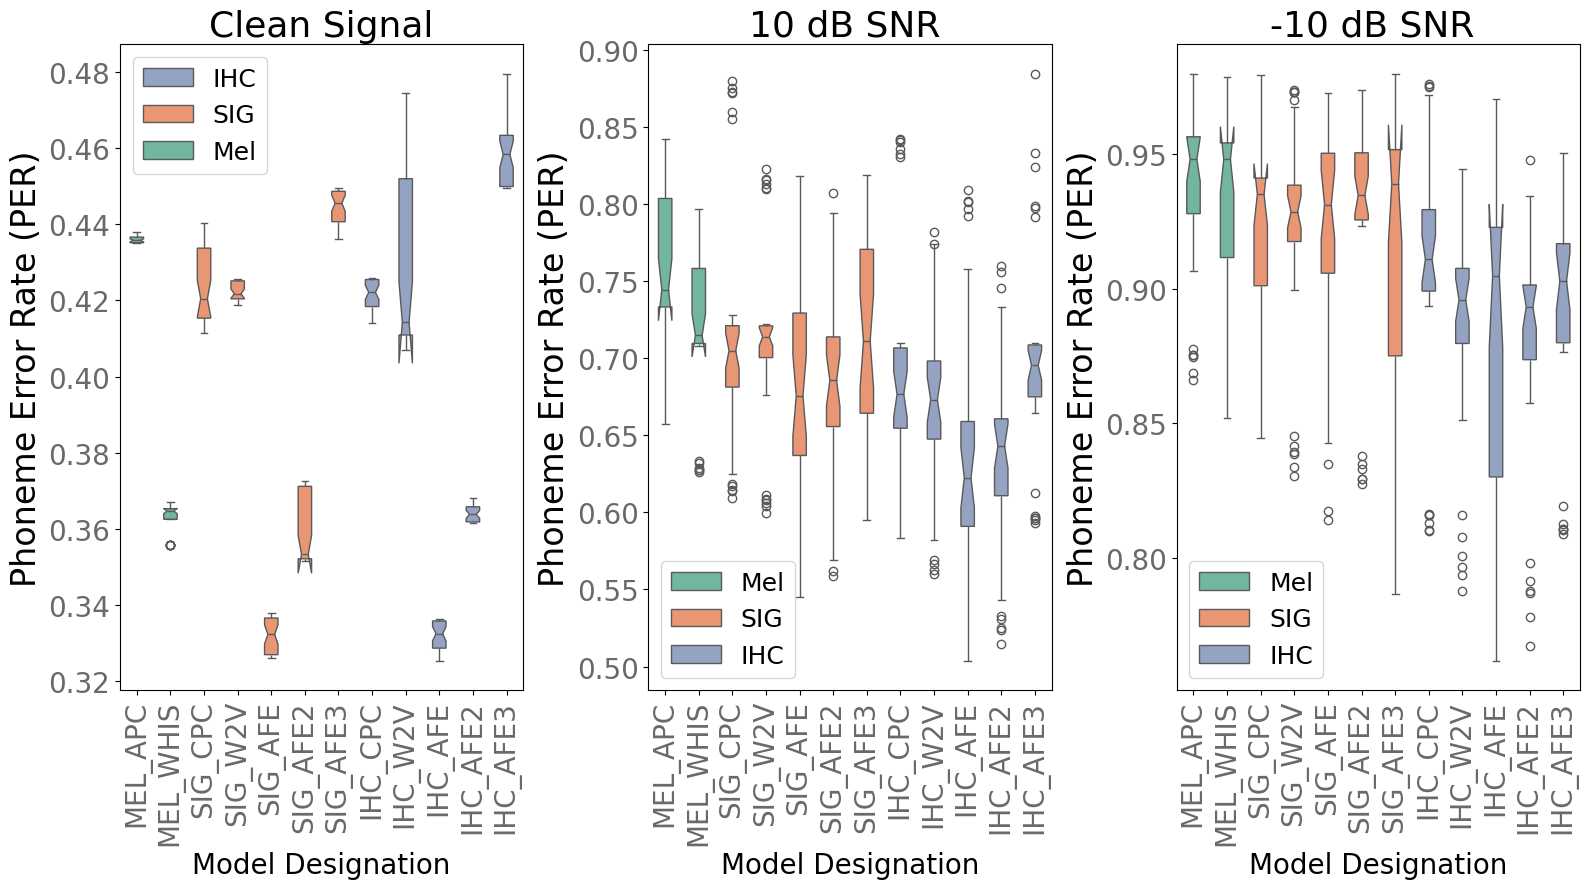

In [10]:
mean_PER=IHC_noise_PER()

In [11]:
def model_compare(m1="MEL_WHIS", m2="IHC_AFE2"):
    ###################################
    #Get the range of different model performance for each designation
    models=complete_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=complete_df[["Designation", "SNR", "Model Type"]].groupby(["Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=complete_df[["Designation", "SNR", "Input Type"]].groupby(["Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()

    #Assert that mean_PER has all the rows it should have
    assert(len(mean_PER)==len(models)*len(complete_df["SNR"].unique()))
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}
    markers={"SIG": "^", "Mel": "o", "IHC": "D"}

    fig, (ax)=plt.subplots( figsize=(16, 9))

    #We only want the models in the order, so take a subset of mean_PER
    types=complete_df["Model Type"].unique()
    order=['APC', 'WHIS', 'CPC', 'W2V', 'AFE', 'AFE2', 'AFE3']
    designated=['MEL_APC', 'MEL_WHIS', 'SIG_CPC', 'IHC_CPC', 'SIG_W2V', 'IHC_W2V', 'SIG_AFE', 'IHC_AFE', 'SIG_AFE2', 'SIG_AFE3' ,'IHC_AFE2', 'IHC_AFE3']
    mean_PER=mean_PER[mean_PER["Model Type"].isin(order)]
    mean_PER=mean_PER[mean_PER["Designation"].isin(designated)]

    x = np.array([0,1,2,3, 4, 5, 6, 7, 8, 9])
    #SNRs=["Clean", 30, 25, 20, 15, 10, 5, 0, -5, -10]
    SNRs=[-10, -5, 0, 5, 10, 15, 20, 25, 30, "Clean"]
    plt.xticks(x, SNRs)
    
    mean_PER["SNR"]=mean_PER["SNR"].cat.reorder_categories(SNRs)
    
    models_df=complete_df[complete_df["Designation"].isin(designated)]

    models=[m1, m2]
    for model in models:
        sub_PER=mean_PER[mean_PER["Designation"]==model]
        input=sub_PER["Input Type"].iloc[0]
        #sub_PER= sub_PER.sort_values("SNR", ascending=True)

        print(sub_PER["PER"])
        ax.plot(x, sub_PER["PER"], color=line_colour[input], label=model, alpha=0.7)
        ax.fill_between(x, sub_PER["Lower Range"], sub_PER["Upper Range"], color=colours[input], alpha=0.1)
        #ax.fill_between(x, sub_PER["First Quartile"], sub_PER["Third Quartile"], color=colours[input], alpha=0.3)
        ax.set_ylim(0.3, 1)
        #ax[i, j].set_title("%s Model " %type)
        #ax.invert_xaxis()

    plt.legend(fontsize=20)
    plt.title("Comparison of Model's Phoneme Recognition Ability over Noise", fontsize=26)
    plt.ylabel("Phoneme Error Rate (PER)", fontsize=24)
    plt.xlabel("Signal-to-Noise Ratio (SNR)", fontsize=24)
    plt.tick_params(axis='x',  labelcolor="dimgray", rotation=90, labelsize=20)
    plt.tick_params(axis='y',  labelcolor="dimgray", rotation=90, labelsize=20)
    fig.tight_layout()

    plt.savefig("Graphs/ModelComparison.pdf".format(noise), format="pdf", bbox_inches="tight")

    return mean_PER

/tmp/ipykernel_3158806/3900486507.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_PER=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).mean()
/tmp/ipykernel_3158806/3900486507.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_PER["Upper Range"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(1)["PER"]
/tmp/ipykernel_3158806/3900486507.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

100    0.931343
101    0.907621
102    0.865551
103    0.801279
104    0.717139
105    0.619508
106    0.522443
107    0.444879
108    0.393794
109    0.363354
Name: PER, dtype: float64
0    0.885126
1    0.850525
2    0.799219
3    0.725633
4    0.635618
5    0.542985
6    0.466372
7    0.415060
8    0.377885
9    0.331879
Name: PER, dtype: float64


,Designation,SNR,PER,Accuracy,Upper Range,Lower Range,Third Quartile,First Quartile,std,Model Type,Input Type
0,IHC_AFE,-10,0.885126,0.114874,0.970565,0.761602,0.922764,0.830008,0.060090,AFE,IHC
1,IHC_AFE,-5,0.850525,0.149475,0.963148,0.707268,0.895100,0.802412,0.072581,AFE,IHC
2,IHC_AFE,0,0.799219,0.200781,0.935425,0.645051,0.845703,0.759446,0.082180,AFE,IHC
3,IHC_AFE,5,0.725633,0.274367,0.880944,0.573821,0.771335,0.684707,0.087182,AFE,IHC
4,IHC_AFE,10,0.635618,0.364382,0.808879,0.503580,0.658910,0.590901,0.093218,AFE,IHC
...,...,...,...,...,...,...,...,...,...,...,...
185,SIG_W2V,15,0.627185,0.372815,0.773069,0.531223,0.619295,0.597496,0.076811,W2V,SIG
186,SIG_W2V,20,0.544230,0.455770,0.726087,0.475117,0.512391,0.493259,0.091218,W2V,SIG
187,SIG_W2V,25,0.493845,0.506155,0.681070,0.441946,0.455136,0.446361,0.092444,W2V,SIG
188,SIG_W2V,30,0.453082,0.546918,0.558693,0.425469,0.435159,0.429185,0.046528,W2V,SIG


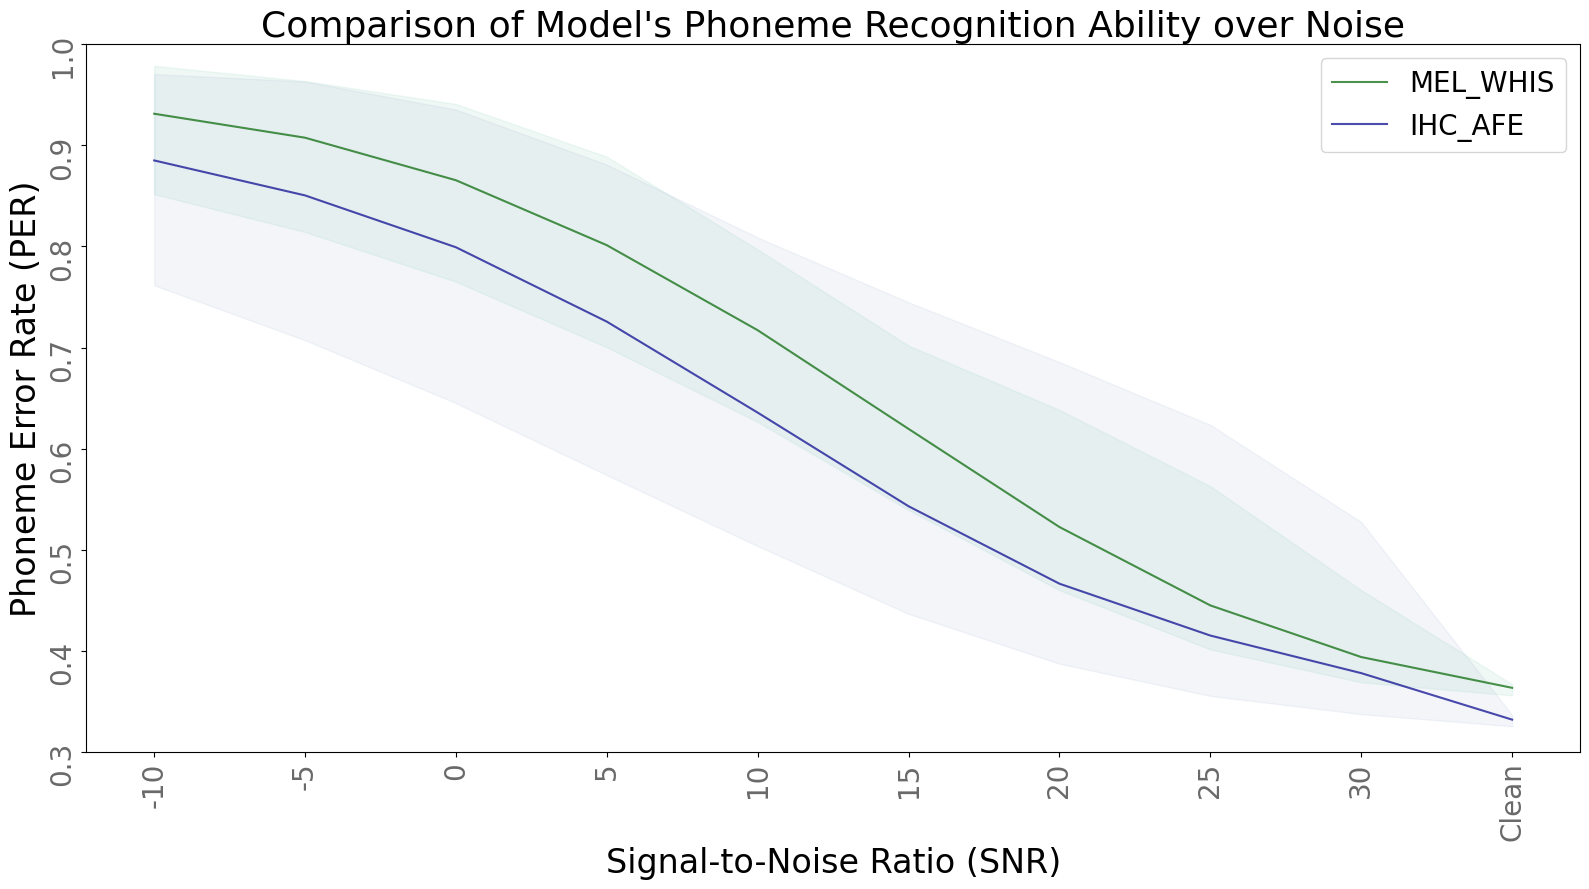

In [12]:
model_compare(m2="IHC_AFE")

In [13]:
def IHC_noise_PER(intervals=["Clean", 10, -10]):
    ###################################
    #Get the range of different model performance for each designation
    models=complete_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=complete_df[["Designation", "SNR", "Model Type"]].groupby(["Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=complete_df[["Designation", "SNR", "Input Type"]].groupby(["Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()

    #Assert that mean_PER has all the rows it should have
    assert(len(mean_PER)==len(models)*len(complete_df["SNR"].unique()))
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}
    markers={"SIG": "^", "Mel": "o", "IHC": "D"}

    fig, (ax)=plt.subplots(ncols=3, figsize=(16, 10))

    #We only want the models in the order, so take a subset of mean_PER
    types=complete_df["Model Type"].unique()
    order=['APC', 'WHIS', 'CPC', 'W2V', 'AFE', 'AFE2', 'AFE3']
    designated=['MEL_APC', 'MEL_WHIS', 'SIG_CPC', 'IHC_CPC', 'SIG_W2V', 'IHC_W2V', 'SIG_AFE', 'IHC_AFE', 'SIG_AFE2', 'IHC_AFE2', 'IHC_AFE3']
    mean_PER=mean_PER[mean_PER["Model Type"].isin(order)]
    mean_PER=mean_PER[mean_PER["Designation"].isin(designated)]
    
    models_df=complete_df[complete_df["Designation"].isin(designated)]
    
    differences={}
    #Plot each snr
    for ii, snr in enumerate(intervals):
        #Get the subset at the SNR value
        #Get the max difference between input sizes of the same PER
        y_size=0.0
        for i, n in enumerate(complete_df["SNR"].unique()):
            subcheck=complete_df[complete_df["SNR"]==n]
            y_now=max(subcheck["PER"]) - min(subcheck["PER"])+0.02
            if i==0:
                y_size=y_now
            elif y_now > y_size:
                y_size=y_now
        print(y_size)

        subset=complete_df[complete_df["SNR"]==snr]
        sub_mean=mean_PER[mean_PER["SNR"]==snr]
        #print(subset)
        inputs=["Mel", "SIG", "IHC"]
        
        for input in inputs:
            sub_PER=sub_mean[sub_mean["Input Type"]==input]
            
            #ax[ii].scatter(mean_PER["Designation"], mean_PER["PER"], c=line_colour[means["Input Type"].iloc[0]], label=input, s=90, marker='_')
            ax[ii].scatter(sub_PER["Designation"], sub_PER["PER"],c=line_colour[sub_PER["Input Type"].iloc[0]], label=input, s=150, marker=markers[sub_PER["Input Type"].iloc[0]], alpha=0.65)#, label=labels)
            ax[ii].errorbar(sub_PER["Designation"], sub_PER["PER"], yerr=sub_PER["std"], c=line_colour[sub_PER["Input Type"].iloc[0]], fmt='o', alpha=0.3)

            if input=="SIG":
                sig_models=sub_PER["PER"].to_numpy()

        #sub_df=models_df[models_df["SNR"]==snr]
        #sns.boxplot(x="Designation", y="PER", hue="Input Type", order=["MEL_APC", "SIG_CPC", "SIG_W2V", "SIG_AFE", "SIG_AFE2", "IHC_CPC", "IHC_W2V", "IHC_AFE", "IHC_AFE2"], palette=colours, data=sub_df, ax=ax[ii])
        
        #IHC_models=sub_PER["PER"].to_numpy()
        #print(np.subtract(sig_models, IHC_models))
        #print("At SNR %s, the average difference in performance is %f. \n" %(snr, np.average(np.subtract(sig_models, IHC_models))*100))
        
        
        #ax[ii].fill_between(sub_PER["SNR"], sub_PER["Lower Range"], sub_PER["Upper Range"], color=colours[input], alpha=0.5)
        #ax[ii].set_ylim(0.3, 1)
        ax[ii].legend(fontsize=18)
        if(snr == "Clean"):
            ax[ii].set_title("At SNR: Clean Signal", fontsize=26)
        else:
            ax[ii].set_title("At SNR: %s dB " %snr, fontsize=26)
        ax[ii].set_ylabel("Phoneme Error Rate (PER)", fontsize=24)
        ax[ii].set_xlabel("Model Designation",  fontsize=20)
        ax[ii].tick_params(axis='x',  labelcolor="dimgray", rotation=90, labelsize=20)
        ax[ii].tick_params(axis='y', labelcolor="dimgray", labelsize=20)
        
        
        #ax[ii].set_xticklabels(ax[ii].get_xticks(), rotation=60, fontsize=18)
#ax[ii].invert_xaxis()
        #Plot what happens if you simply predict the main phoneme type every time
            

    fig.suptitle("Phoneme Recognition in Averaged Noise", fontsize=30)

    fig.tight_layout()

    plt.savefig("Graphs/PER_Averaged_Noise_v2.pdf".format(noise), format="pdf", bbox_inches="tight")

    return mean_PER

/tmp/ipykernel_3158806/3709528208.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_PER=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).mean()
/tmp/ipykernel_3158806/3709528208.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_PER["Upper Range"]=complete_df[["Designation", "SNR", "PER", "Accuracy"]].groupby(["Designation", "SNR"]).quantile(1)["PER"]
/tmp/ipykernel_3158806/3709528208.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

0.41073455861438024
0.41073455861438024
0.41073455861438024


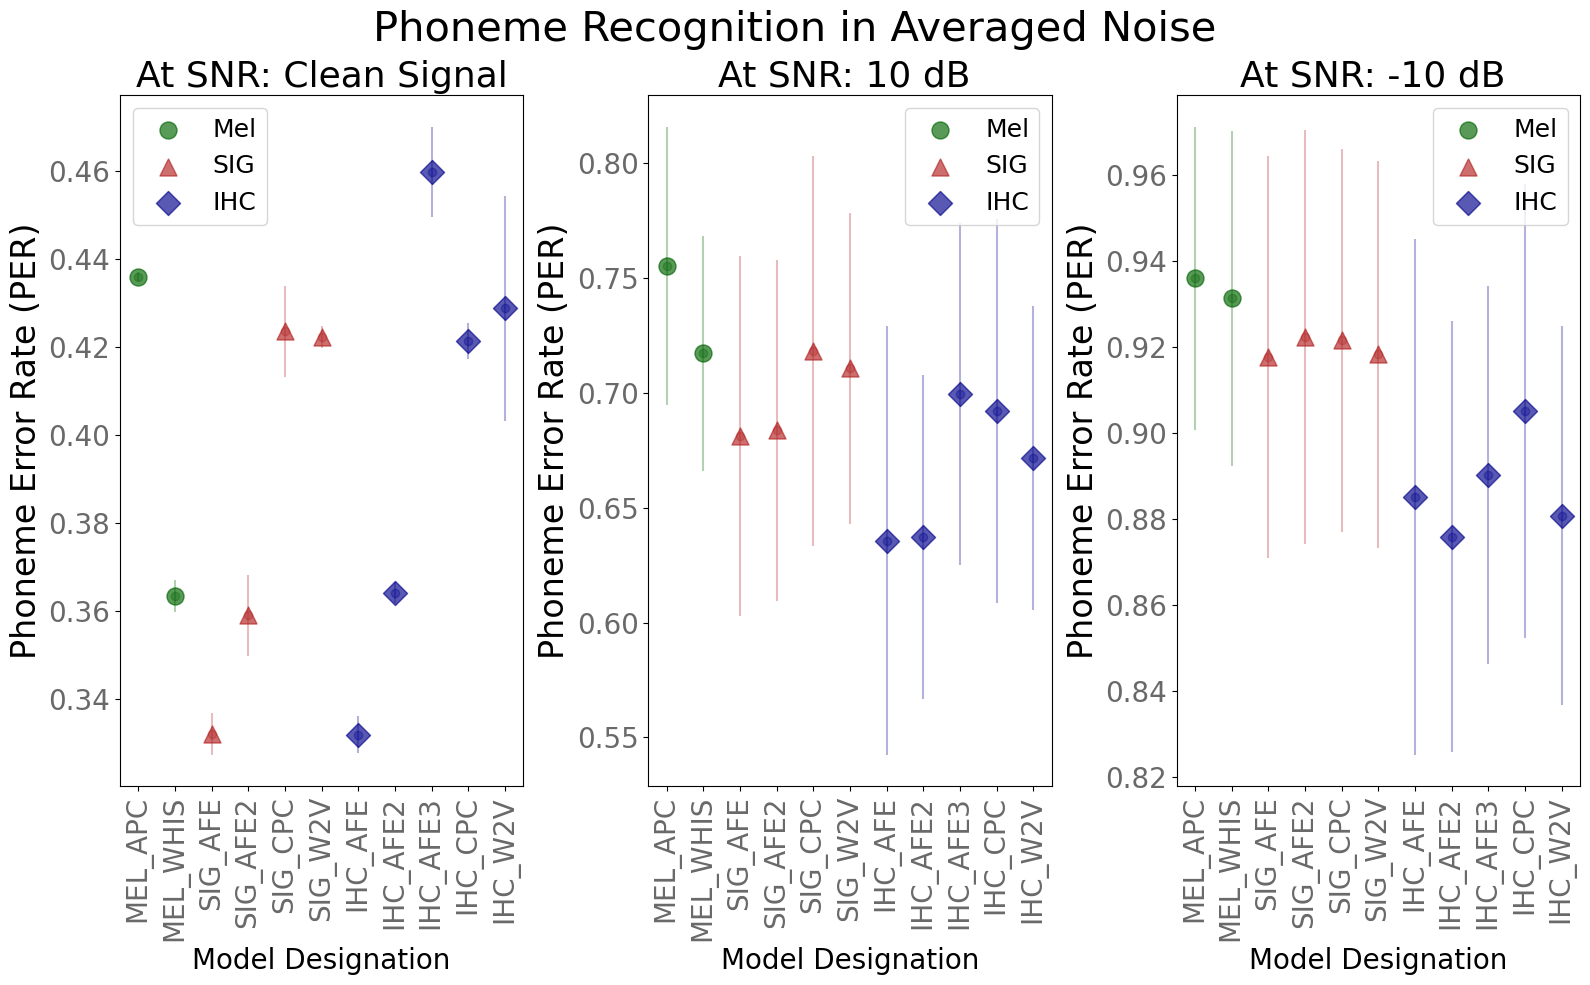

In [14]:
mean_PER=IHC_noise_PER()

## When are IHCs better than inputs than Signal? Does this vary by noise type?


In [15]:
def noise_reaction():
    #Manipulate the complete df to get the results that correspond to model performance spread for input, noise type, model and designation
    ###########################################################
    #Get the range of different model performance for each designation
    models=complete_df['Designation'].unique()
    
    #Get a description of the spread for each input, model and designation
    mean_PER=complete_df[["Designation", "Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=complete_df[["Designation", "Noise Type","SNR", "Model Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=complete_df[["Designation","Noise Type", "SNR", "Input Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()
    #Remove the clean columns in this case
    mean_PER=mean_PER[mean_PER["Noise Type"] != "Clean"]
    mean_PER=mean_PER[mean_PER["Designation"]!="MEL_APC_small"]
    ##########################################

    #Set the colours and labels we are going to use
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}
    noise_dict={"White":"White", "air_conditioner": "Air Conditioner", "children_playing": "Children Playing", "dog_bark": "Dog Barking", "street_music": "Street Music"}

    #We are only considering these models for this paper
    order=['APC', 'CPC', 'W2V', 'AFE', 'AFE2']
    designated=['MEL_APC', 'SIG_CPC', 'IHC_CPC', 'SIG_W2V', 'IHC_W2V', 'SIG_AFE', 'IHC_AFE', 'SIG_AFE2', 'IHC_AFE2']
    mean_PER=mean_PER[mean_PER["Model Type"].isin(order)]
    mean_PER=mean_PER[mean_PER["Designation"].isin(designated)]
    mean_PER["PER"]=mean_PER["PER"].apply(lambda x:  "%0.2f" %(x*100))
    mean_PER["PER"]=pd.to_numeric(mean_PER["PER"])
    mean_PER["Model Type"]=mean_PER["Model Type"].astype("category").cat.reorder_categories(order)

    #Order the SNRs
    SNRs=["Clean", 30, 25, 20, 15, 10, 5, 0, -5, -10]
    mean_PER["SNR"]=mean_PER["SNR"].cat.reorder_categories(SNRs)
    
    #Loop through the noise types
    noise_types=mean_PER["Noise Type"].unique()

    fig, (ax)=plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(14, 9))
    
    for i, noise in enumerate(noise_types):
        sub_PER=mean_PER[mean_PER["Noise Type"]==noise]

        show_mean=sub_PER[sub_PER["Input Type"]=="IHC"].pivot(index="Model Type", columns="SNR", values="PER").mean()-sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Model Type", columns="SNR", values="PER").mean()
        show_third=sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Model Type", columns="SNR", values="Upper Range").mean()*100-sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Model Type", columns="SNR", values="PER").mean()
        show_first=sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Model Type", columns="SNR", values="Lower Range").mean()*100-sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Model Type", columns="SNR", values="PER").mean()
        show_IHC_third=sub_PER[sub_PER["Input Type"]=="IHC"].pivot(index="Model Type", columns="SNR", values="Upper Range").mean()*100-sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Model Type", columns="SNR", values="PER").mean()
        show_IHC_first=sub_PER[sub_PER["Input Type"]=="IHC"].pivot(index="Model Type", columns="SNR", values="Lower Range").mean()*100-sub_PER[sub_PER["Input Type"]=="SIG"].pivot(index="Model Type", columns="SNR", values="PER").mean()
        #print(show_IHC_third)
        #print(show_IHC_first)

        #Set the colour based on if the using IHC improves the performance or niot (reduces PER)
        colours=[]
        for val in show_mean:
            if(val)> 0:
                colours.append("firebrick")
            else:
                colours.append("#a1d99b")
    
    
        b=i%2
        a=i//2
        #plt.bar(show_third.index, show_third.values)
        show_third.plot.bar(color="#bdbdbd", width=0.8,  hatch="/", alpha=0.3, label="SIG Average Range", ax=ax[a, b])
        show_first.plot.bar(color="#bdbdbd", width=0.8,  hatch="/", alpha=0.3, label="SIG Average Range", ax=ax[a, b])
        #show_IHC_third.plot.bar(color="#fee6ce", width=0.6,   alpha=0.9)
        #show_IHC_first.plot.bar(color="#fee6ce", width=0.6,   alpha=0.9, label="IHC Range")
        show_mean.plot.bar(color=colours, ax=ax[a, b], label="IHC Average Improvement", alpha=0.9)
        ax[a, b].axhline(0, color="black", lw=1, linestyle='--')
        #ax[a, b].set_ylabel("PER % Change", fontsize=18)
        #ax[a, b].set_xlabel("Signal-to-Noise Ratio (SNR)", fontsize=18)
        #ax[a, b].legend(fontsize=16)
        ax[a, b].set_title(noise_dict[noise], fontsize=26)
        #ax[a, b].grid()
        #if b==0: 
        #    start, end = ax[a,b].get_ylim()
        #    print(start + " , "+ end)
       #     ax[a,b].set_xticklabels(np.arange(start, end, 2.5))
            #ax[a, b].tick_params(axis='y', labelsize=20)
            
            #ax[a, b].tick_params(axis='x', labelbottom=True, labelsize=20)
        
        
            #plt.setp(ax[a, b].get_xticklabels(), visible=True)

    import matplotlib.patches as mpatches
    #legend_colours={"SIG InterQuartile Range" : "#bdbdbd", "IHC increases PER": "firebrick", "IHC decreases PER": "#a1d99b"}
    #hatching={"SIG InterQuartile Range": "/", "IHC increases PER": None, "IHC decreases PER": None}
    
    legend_handles = [
    mpatches.Patch(facecolor="#bdbdbd", label="InterQuartile Range of Signal", hatch="/", alpha=0.3),
    mpatches.Patch(color="firebrick", label="IHCs increase PER", alpha=0.9),
    mpatches.Patch(color="#a1d99b", label="IHCs decrease PER", alpha=0.9),
    ]

    plt.rcParams['xtick.labelsize']=20
    plt.rcParams['ytick.labelsize']=14

    ax[1, 1].tick_params(axis='x', labelbottom=True, labelcolor="Black")
    ax[1,1].set_xticklabels(ax[2, 1].get_xticklabels())
    ax[2, 1].set_visible(False)
    ax[2, 0].set_xlabel("0", visible=False)
    #ax[1, 1].set_visible(True)
    #ax[1, 1].set_xlabel("Signal-to-Noise Ratio (SNR)", fontsize=20)
    # Add the legend to the figure
    fig.legend(handles=legend_handles,  bbox_to_anchor=(.95, 0.35),  fontsize=20)
    fig.supylabel(u'Δ PER (%)', fontsize=26)
    fig.supxlabel("SNR (dB)", fontsize=26)
    #fig.suptitle("Average Effect of using IHCs instead of Signal as Input on PER", fontsize=28)
    plt.subplots_adjust(right=0.9)
    fig.tight_layout()
    fig.show()

    plt.savefig("Graphs/PER_by_noisetype.pdf".format(noise), format="pdf", bbox_inches="tight")

/tmp/ipykernel_3158806/102736927.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_PER=complete_df[["Designation", "Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "Designation", "SNR"]).mean()
/tmp/ipykernel_3158806/102736927.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_PER["Upper Range"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(1)["PER"]
/tmp/ipykernel_3158806/102736927.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

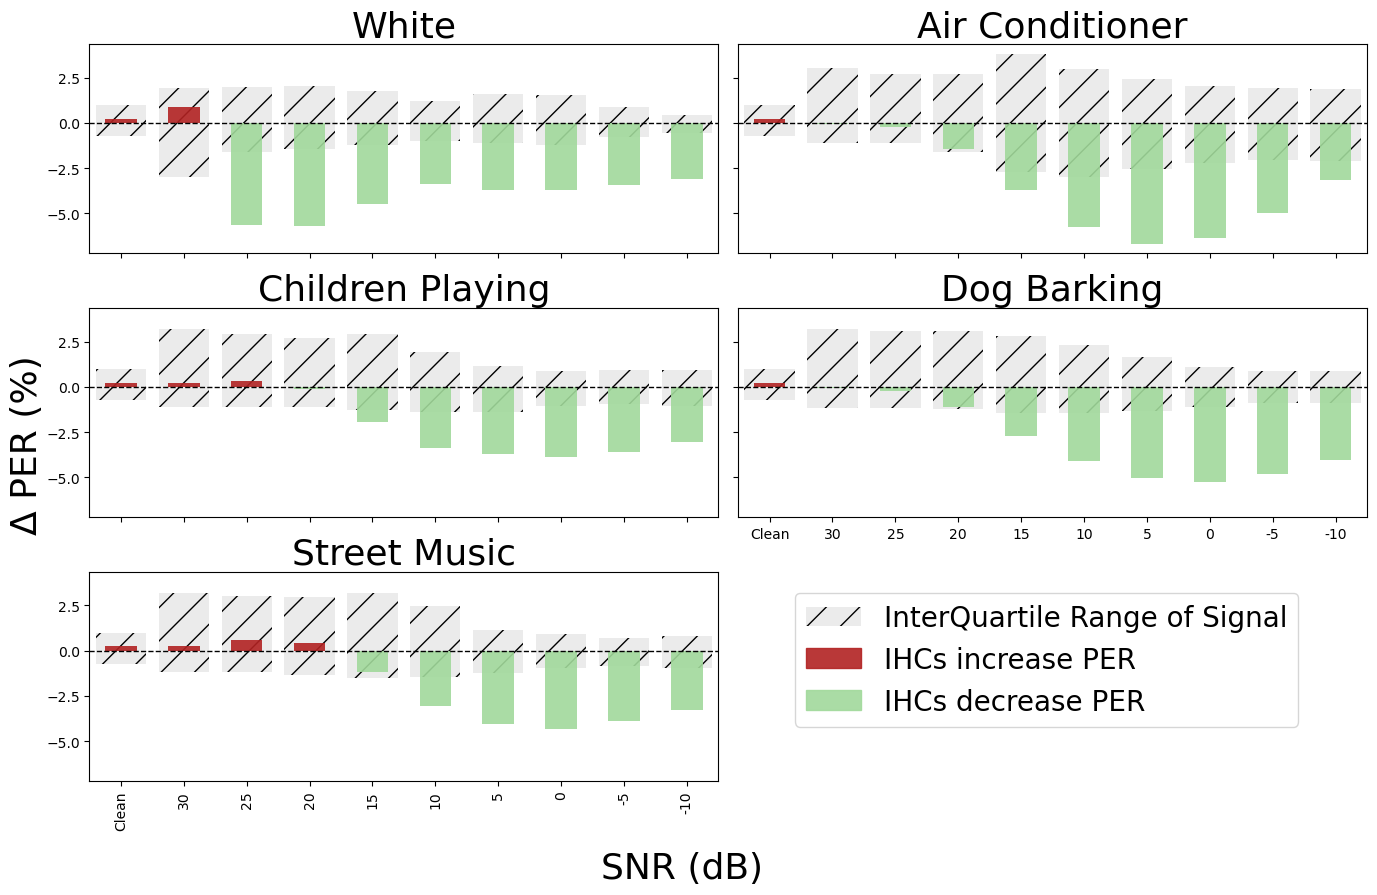

In [16]:
noise_reaction()

In [17]:
def best_performing():
    #Get the range of different model performance for each designation
    models=complete_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=complete_df[["Designation", "Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=complete_df[["Designation", "Noise Type","SNR", "Model Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=complete_df[["Designation","Noise Type", "SNR", "Input Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Input Type"]

    mean_PER=mean_PER.reset_index()

    mean_PER=mean_PER[mean_PER["Noise Type"] != "Clean"]
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}

    #We are only considering these models for this paper
    #order=['APC', 'CPC', 'W2V', 'AFE', 'AFE2']
    designated=['MEL_APC', 'SIG_CPC', 'IHC_CPC', 'SIG_W2V', 'IHC_W2V', 'SIG_AFE', 'IHC_AFE', 'SIG_AFE2', 'IHC_AFE2']
    #mean_PER=mean_PER[mean_PER["Model Type"].isin(order)]
    mean_PER=mean_PER[mean_PER["Designation"].isin(designated)]

    types=mean_PER["Designation"].unique()
    noisys=mean_PER["Noise Type"].unique()
    order=['APC', 'CPC', 'W2V', 'AFE', 'AFE2']

    table_list=[]
    
    
    for model in types:
        table_row={}
        table_row["Designation"]=model
        table_row["Total"]=0
        table_row["Range"]=0
        table_row["std"]=0
        
        
        for i, noise in enumerate(noisys):
            for snr in SNRs:
                if snr=="Clean":
                    if i!=0:
                        continue
                    table_row["Clean PER"]=mean_PER[(mean_PER['Designation'] ==model) & (mean_PER['Noise Type'] ==noise) & (mean_PER["SNR"]== snr)]["PER"].iloc[0]
                    
                table_row["Total"]=mean_PER[(mean_PER['Designation'] ==model) & (mean_PER['Noise Type'] ==noise) & (mean_PER["SNR"]== snr)]["PER"].iloc[0]+table_row["Total"]
                table_row["Range"]=mean_PER[(mean_PER['Designation'] ==model) & (mean_PER['Noise Type'] ==noise) & (mean_PER["SNR"]== snr)]["Upper Range"].iloc[0]\
                -mean_PER[(mean_PER['Designation'] ==model)& (mean_PER['Noise Type'] ==noise)  & (mean_PER["SNR"]== snr)]["Lower Range"].iloc[0]+table_row["Range"]
                table_row["std"]=mean_PER[(mean_PER['Designation'] ==model)& (mean_PER['Noise Type'] ==noise)  & (mean_PER["SNR"]== snr)]["std"].iloc[0]+table_row["std"]

        table_row["Avg PER"]=table_row["Total"]/(len(SNRs)*len(noisys) -4)
        table_row["Avg Range"]=table_row["Range"]/(len(SNRs)*len(noisys) -4)
        table_row["Avg STD"]=table_row["std"]/(len(SNRs)*len(noisys) -4)
        #print(table_row)
        table_list.append(table_row)


    table=pd.DataFrame(table_list)
    table=table.drop(columns=["Total", "Range", "std"])
    table.sort_values(by="Avg PER", ascending=True, inplace=True)
    table["Clean PER"]=table["Clean PER"].apply(lambda x: "%0.2f" %(x*100))
    table["PER over SNRs"]=table["Avg PER"].apply(lambda x: "%0.2f" %(x*100))
    table["Range"]=table["Avg Range"].apply(lambda x: "%0.2f" %(x*100))
    table["STD"]=table["Avg STD"].apply(lambda x: "%0.2f" %(x*100))
    table=table.drop(columns=["Avg PER", "Avg Range", "Avg STD"])
    print(table.to_latex())

In [18]:
best_performing()

/tmp/ipykernel_3158806/1154044358.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_PER=complete_df[["Designation", "Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "Designation", "SNR"]).mean()
/tmp/ipykernel_3158806/1154044358.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_PER["Upper Range"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(1)["PER"]
/tmp/ipykernel_3158806/1154044358.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas.

\begin{tabular}{llllll}
\toprule
 & Designation & Clean PER & PER over SNRs & Range & STD \\
\midrule
1 & IHC_AFE2 & 36.42 & 62.49 & 2.85 & 1.07 \\
0 & IHC_AFE & 33.19 & 62.66 & 4.78 & 1.81 \\
5 & SIG_AFE & 33.20 & 65.65 & 7.61 & 2.91 \\
3 & IHC_W2V & 42.88 & 65.79 & 4.62 & 1.77 \\
6 & SIG_AFE2 & 35.90 & 66.35 & 2.50 & 1.02 \\
2 & IHC_CPC & 42.14 & 68.06 & 1.35 & 0.51 \\
8 & SIG_W2V & 42.23 & 68.90 & 1.59 & 0.59 \\
7 & SIG_CPC & 42.36 & 69.37 & 1.83 & 0.70 \\
4 & MEL_APC & 43.61 & 72.27 & 1.57 & 0.58 \\
\bottomrule
\end{tabular}



In [19]:
def noise_reaction(model="AFE2"):
    ###################################
    #Get the range of different model performance for each designation
    models=complete_df['Designation'].unique()

    #Get a description of the spread for each input, model and designation
    mean_PER=complete_df[["Designation", "Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "Designation", "SNR"]).mean()
    mean_PER["Upper Range"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(1)["PER"]
    mean_PER["Lower Range"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0)["PER"]
    mean_PER["Third Quartile"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.75)["PER"]
    mean_PER["First Quartile"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(0.25)["PER"]
    mean_PER["std"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).std()["PER"]
    mean_PER["Model Type"]=complete_df[["Designation", "Noise Type","SNR", "Model Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Model Type"]
    mean_PER["Input Type"]=complete_df[["Designation","Noise Type", "SNR", "Input Type"]].groupby(["Noise Type","Designation", "SNR"]).first()["Input Type"]
    
    mean_PER=mean_PER.reset_index()
    
    mean_PER=mean_PER[mean_PER["Noise Type"] != "Clean"]
    ##########################################
    #Graph the results of the performance
    #Set the colours and labels
    line_colour={"SIG": "firebrick", "Mel": "darkgreen", "IHC": "darkblue"}
    labels={"SIG": "Signal", "Mel": "Mel Spectograms", "IHC": "IHCs"}
    colours={"SIG": "#fc8d62", "Mel": "#66c2a5", "IHC": "#8da0cb"}

    #fig, (ax)=plt.subplots(figsize=(12, 7))

    types=complete_df["Model Type"].unique()
    order=['APC', 'CPC', 'W2V', 'AFE', 'AFE2']
    
    mean_PER=mean_PER[mean_PER["Designation"]!="MEL_APC_small"]

    mean_PER=mean_PER[mean_PER["Model Type"].isin(order)]
    mean_PER["PER"]=mean_PER["PER"].apply(lambda x:  "%0.2f" %(x*100))
    mean_PER["PER"]=pd.to_numeric(mean_PER["PER"])
    mean_PER["Model Type"]=mean_PER["Model Type"].astype("category").cat.reorder_categories(order)
    
    mean_PER=mean_PER[mean_PER["Model Type"]==model]
    #mean_PER["SNR"]=mean_PER["SNR"].astype(int)
    #mean_PER=mean_PER.sort_values(by="SNR", ascending=False)
    latex_PER=mean_PER.pivot(index=["Noise Type", "Input Type",], columns="SNR", values="PER")
    latex_PER=latex_PER.reindex(["Clean", 30, 25, 20, 15, 10, 5, 0, -5, -10], axis=1)
    print(latex_PER.to_latex(float_format="%0.2f"))

    show_mean=mean_PER[mean_PER["Input Type"]=="IHC"].pivot(index="Noise Type", columns="SNR", values="PER").mean()-mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
    #show_mean=show_mean.sort_values(ascending=False)
    show_third=mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="Upper Range").mean()*100-mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
    show_first=mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="Lower Range").mean()*100-mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
    show_IHC_third=mean_PER[mean_PER["Input Type"]=="IHC"].pivot(index="Noise Type", columns="SNR", values="Upper Range").mean()*100-mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
    show_IHC_first=mean_PER[mean_PER["Input Type"]=="IHC"].pivot(index="Noise Type", columns="SNR", values="Lower Range").mean()*100-mean_PER[mean_PER["Input Type"]=="SIG"].pivot(index="Noise Type", columns="SNR", values="PER").mean()
    
    colours=[]
    for val in show_mean:
        if(val)> 0:
            colours.append("firebrick")
        else:
            colours.append("#a1d99b")
    
    fig, (ax)=plt.subplots( figsize=(12, 7))

    
    show_third.plot.bar(color="#bdbdbd", width=0.65,  hatch="/", alpha=0.4)
    show_first.plot.bar(color="#bdbdbd", width=0.65,  hatch="/", alpha=0.4, label="SIG Average Range")
    #show_IHC_third.plot.bar(color="#fee6ce", width=0.6,   alpha=0.9)
    #show_IHC_first.plot.bar(color="#fee6ce", width=0.6,   alpha=0.9, label="IHC Range")
    show_mean.plot.bar(color=colours, ax=ax, label="IHC Average Improvement", alpha=0.9)

    ax.invert_xaxis()
    ax.set_ylabel("PER % Change", fontsize=18)
    ax.set_xlabel("Signal-to-Noise Ratio (SNR)", fontsize=18)
    ax.legend(fontsize=16)
    fig.suptitle("Effect of using IHCs over SIG on PER, averaged across Noise Type", fontsize=20)
    fig.tight_layout()
    fig.show()

\begin{tabular}{llrrrrrrrrrr}
\toprule
 & SNR & Clean & 30 & 25 & 20 & 15 & 10 & 5 & 0 & -5 & -10 \\
Noise Type & Input Type &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{White} & IHC & 36.42 & 42.65 & 49.19 & 56.25 & 64.84 & 74.15 & 81.18 & 86.33 & 90.07 & 92.46 \\
 & SIG & 35.90 & 51.30 & 62.33 & 68.20 & 73.45 & 79.47 & 85.83 & 91.02 & 94.75 & 96.83 \\
\cline{1-12}
\multirow[t]{2}{*}{air_conditioner} & IHC & 36.42 & 38.11 & 40.53 & 45.14 & 53.10 & 62.64 & 71.25 & 78.28 & 83.79 & 87.93 \\
 & SIG & 35.90 & 37.30 & 39.55 & 44.76 & 54.83 & 67.56 & 78.63 & 85.99 & 90.45 & 93.23 \\
\cline{1-12}
\multirow[t]{2}{*}{children_playing} & IHC & 36.42 & 37.95 & 40.41 & 45.85 & 54.79 & 65.23 & 74.28 & 81.45 & 86.57 & 89.94 \\
 & SIG & 35.90 & 37.23 & 39.84 & 46.62 & 58.27 & 70.28 & 79.94 & 87.08 & 91.91 & 94.81 \\
\cline{1-12}
\multirow[t]{2}{*}{dog_bark} & IHC & 36.42 & 37.51 & 39.09 & 41.97 & 46.60 & 52.84 & 59.65 & 66.40 & 72.76 & 78.48 \\
 & SIG & 35.90 & 36.97 & 38.84 & 42.62 &

/tmp/ipykernel_3158806/49871089.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_PER=complete_df[["Designation", "Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type", "Designation", "SNR"]).mean()
/tmp/ipykernel_3158806/49871089.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_PER["Upper Range"]=complete_df[["Designation","Noise Type", "SNR", "PER", "Accuracy"]].groupby(["Noise Type","Designation", "SNR"]).quantile(1)["PER"]
/tmp/ipykernel_3158806/49871089.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass 

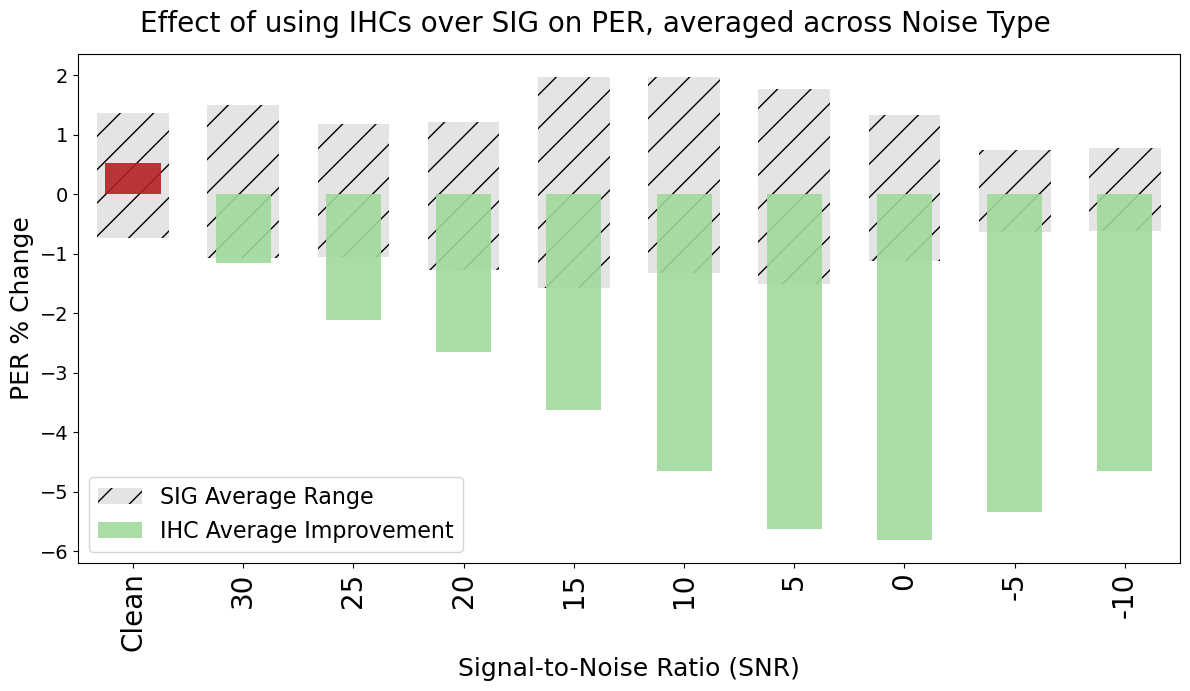

In [20]:
noise_reaction()

## Time difference Between models

Here we will calculate the average and maximum difference between using IHCs vs the signal alone at test time.

In [21]:
import os

model_to_designation={"CPC_Encoder Checkpoints":"SIG_CPC", "IHC_CPC Checkpoints": "IHC_CPC", "SIG_Extract_2.0 Checkpoints":"SIG_AFE2", "IHC_Extract_2.0 Checkpoints": "IHC_AFE2", 
                      "Wav2Vec2.0_Encoder Checkpoints": "SIG_W2V", "IHC_Wav2Vec2 Checkpoints":"IHC_W2V", "Extract Checkpoints": "SIG_AFE", "IHC_Extract Checkpoints":"IHC_AFE", 
                     "MelSimple_MLP Checkpoints": "MEL_APC", "Whisper Checkpoints":"MEL_WHIS", "IHC_Extract_3.0 Checkpoints": "IHC_AFE3", "SIG_Extract_3.0 Checkpoints": "SIG_AFE3" }

model_times={"SIG_CPC":[], "IHC_CPC":[], "SIG_W2V":[], "IHC_W2V":[], "SIG_AFE":[], "IHC_AFE":[], "SIG_AFE2":[], "IHC_AFE2":[], "MEL_APC":[], "MEL_WHIS":[], "IHC_AFE3":[], "SIG_AFE3":[]}

#Get the average, longest and shortest times for each model
row_dict={}
#Go through all the models in Model Checkpoints
for models in os.listdir("Model Checkpoints"):
    #Omits any things that aren't models
    if " Checkpoints" in models and "80" not in models and "512" not in models and models != "MelSimple Checkpoints":
        row={}
        
        import_accuracies=pd.read_csv("Model Checkpoints/{}/TrainingLoss_PER_df.csv".format(models))
        model_times[model_to_designation[models]].extend(import_accuracies["Test Time"].to_list())
        #print(import_accuracies)
        
        for subtrain in os.listdir("Model Checkpoints/{}".format(models)):
            if "kFold Eval" in subtrain:
                import_accuracies=pd.read_csv("Model Checkpoints/{}/{}/TrainingLoss_PER_df.csv".format(models, subtrain))
                model_times[model_to_designation[models]].extend(import_accuracies["Test Time"].to_list())

        row["Average"]=np.array(model_times[model_to_designation[models]]).mean()
        #row["Shortest"]=np.array(model_times[model_to_designation[models]]).min()
        row["Longest"]=np.array(model_times[model_to_designation[models]]).max()
        #row["Model Type"]=model_to_designation[models].split('_')[1]
        #row["Input"]=model_to_designation[models].split('_')[0]
        
        row_dict[model_to_designation[models]]=row
        #print(len(model_times[model_to_designation[models]]))

times_df=pd.DataFrame(row_dict)

times_df["CPC difference"]=times_df["IHC_CPC"]-times_df["SIG_CPC"]
times_df["W2V difference"]=times_df["IHC_W2V"]-times_df["SIG_W2V"]
times_df["AFE difference"]=times_df["IHC_AFE"]-times_df["SIG_AFE"]
times_df["AFE2 difference"]=times_df["IHC_AFE2"]-times_df["SIG_AFE2"]
times_df["AFE3 difference"]=times_df["IHC_AFE3"]-times_df["SIG_AFE3"]

difference=times_df.drop(columns=["SIG_CPC", "IHC_CPC", "IHC_AFE2", "IHC_W2V", "SIG_AFE2", "IHC_AFE", "MEL_APC", "SIG_AFE", "SIG_W2V"])

difference.T["Average"].mean()  

65.04289000456536

In [22]:
times_df[["SIG_CPC", "SIG_W2V", "SIG_AFE", "SIG_AFE2"]]

,SIG_CPC,SIG_W2V,SIG_AFE,SIG_AFE2
Average,14.342988,8.303745,14.023020,9.699794
Longest,15.618969,9.005232,15.205927,14.811269


In [23]:
times_df

,IHC_AFE3,SIG_CPC,MEL_WHIS,IHC_CPC,IHC_AFE2,IHC_W2V,SIG_AFE2,IHC_AFE,MEL_APC,SIG_AFE,SIG_W2V,SIG_AFE3,CPC difference,W2V difference,AFE difference,AFE2 difference,AFE3 difference
Average,58.785836,14.342988,207.302125,63.186324,56.396030,56.187389,9.699794,66.069126,15.502347,14.023020,8.303745,9.795213,48.843336,47.883644,52.046106,46.696236,48.990623
Longest,98.658161,15.618969,239.983730,67.029939,60.301418,61.531737,14.811269,89.888675,47.290259,15.205927,9.005232,30.416096,51.410970,52.526505,74.682749,45.490149,68.242065


## Signal, Mel vs IHC comparision

In [24]:
print("Taking audio sample from Data/P phoneme.m4a")
file="./Data/P phoneme.m4a"
signal, sr=librosa.load(file, sr=16000)
audio=signal[int(1*sr):int(1.35*sr)]
ipd.Audio(audio, rate=sr)

Taking audio sample from Data/P phoneme.m4a


/tmp/ipykernel_3158806/1438056573.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr=librosa.load(file, sr=16000)
/home/cathaloF/miniconda3/envs/eist/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


/tmp/ipykernel_3158806/3954776041.py:61: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, _ = librosa.load(file, sr=fs)
/home/cathaloF/miniconda3/envs/eist/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Processing Started...
torch.Size([1, 1, 5600])
Processing time of WaveNet model: 0.2897183895111084 s
(80, 3553)


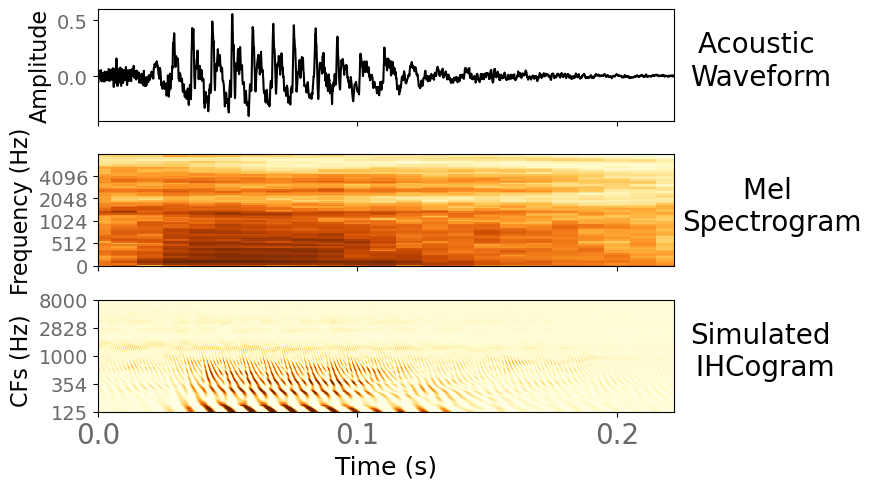

In [25]:
import time
import matplotlib.colors as colors
#Get the WavIHC representation of the sound
# load configuration file  
with open("./IHCApproxNH/config/config31rfa3-1fullSet.yaml",'r') as ymlfile:
        conf = yaml.safe_load(ymlfile)   
device="cuda:0"

labels=[0, 0.1, 0.3]
# number of samples to be skipped due to WaveNet processing    
skipLength = (2**conf['nLayers'])*conf['nStacks']  

sigMax = torch.tensor(55)
ihcogramMax = torch.tensor(1.33)
ihcogramMax = utils.comp(ihcogramMax, conf['scaleWeight'], conf['scaleType'])
fs = 16000

times = np.linspace( 
        0, # start 
        len(audio[skipLength:]) / sr, 
        num = len(audio[skipLength:]) ) 

#Plot the signal and Mel Spectrogram of the sound
fig, (ax) = plt.subplots(nrows=3, sharex=True, figsize=(8, 5))

ax[0].plot(times, audio[skipLength:], color='k')
ax[0].set_title('Acoustic \nWaveform',  fontsize=20, y=0.25, x=1.15)
ax[0].set_ylabel('Amplitude', fontsize=16)
ax[0].tick_params(axis='y', labelcolor="dimgray")

mel=librosa.feature.melspectrogram(y=audio[skipLength:], sr=sr,  n_fft=int(math.ceil(0.025*sr)), hop_length=int(math.ceil(0.01*sr)), n_mels=80)
Mel_db = librosa.power_to_db(mel, ref=np.max)

img=librosa.display.specshow(Mel_db, sr=sr, hop_length=int(math.ceil(0.01*sr)), x_axis='time', y_axis='mel', cmap="YlOrBr", ax=ax[1])
labels=["%0.1f"%l for l in np.arange(0, 0.3, 0.1)]
ax[1].set_xlabel("")
ax[1].set_xticks(np.arange(0, 0.3, 0.1), labels)
ax[1].tick_params(axis='y', labelcolor="dimgray")
ax[1].set_title('Mel \nSpectrogram',fontsize=20, y=0.25, x=1.17)
ax[1].set_ylabel('Frequency (Hz)', fontsize=16)
#fig.colorbar(img, ax=ax[1], format="%+2.f dB")


##################################################################

## initialize WaveNet and load model paramaters
NET = WaveNet.WaveNet(conf['nLayers'],
                                   conf['nStacks'],
                                   conf['nChannels'],
                                   conf['nResChannels'],
                                   conf['nSkipChannels'],
                                   conf['numOutputLayers'])
NET.to(device)
NET.load_state_dict(torch.load("./IHCApproxNH/model/musan31rfa3-1fullSet_20231014-145738.pt",\
                                    map_location=torch.device('cuda:0'), weights_only=True))


   

#Turn the audio into a tensor
signal, _ = librosa.load(file, sr=fs)
signal=signal[int(1*fs):int(1.35*fs)]
signal = signal/np.std(signal)*20e-6*10**(60/20)
signal = signal/sigMax    
signal = signal.to(device)

# segmentation
frame_shift = int(len(signal)*fs)
frame_len = frame_shift + skipLength
sigLen = signal.shape[0]

ihcogram_pred = np.zeros((80,sigLen-skipLength+1))

start_idx = 0
end_idx = 0
frame_idx = 0
        
print("Processing Started...")

start_time = time.time()

# loop over frames
while end_idx < sigLen:
    start_idx = frame_idx*frame_shift
    end_idx = np.min([sigLen,frame_idx*frame_shift + frame_len])

    if sigLen - end_idx < skipLength:
        end_idx = sigLen
    signal_seg = signal[start_idx:end_idx]
    signal_seg = signal_seg.to(device)
    signal_seg=signal_seg.unsqueeze(dim=0)
    signal_seg=signal_seg.unsqueeze(dim=0)
    print(signal_seg.shape)
                     
    # process signal segment and scale back to original range
    ihcogram_pred_seg = NET(signal_seg)
    ihcogram_pred_seg = ihcogram_pred_seg*ihcogramMax    
    ihcogram_pred_seg = utils.invcomp(ihcogram_pred_seg, conf['scaleWeight'], conf['scaleType'])

    # write IHCogram segment into full IHCogram array
    ihcogram_pred_seg = ihcogram_pred_seg.cpu().detach().numpy()
    ihcogram_pred[:,start_idx:end_idx-skipLength+1] = ihcogram_pred_seg 

    frame_idx += 1

end_time = time.time()

elapsed = end_time-start_time
print('Processing time of WaveNet model: ' + str(elapsed) + ' s')
#####################################################################
#Plot the WavIHC representation
climlow = -0.0025
climhigh = 0.06

print(ihcogram_pred.shape)
ax[2].imshow(ihcogram_pred, cmap="YlOrBr", aspect='auto', extent=[0, ihcogram_pred.shape[1]/fs, 80,0], vmin=climlow, vmax=climhigh)
#
ax[2].invert_yaxis()
ax[2].set_xticks(np.arange(0, 0.3, step=0.1))
ax[2].set_yticks(np.arange(0, 81, step=20), labels=["%0.0f"%val for val in np.logspace(np.log10(125), np.log10(8000), num=5)])
ax[2].tick_params(axis='y', labelcolor="dimgray")
ax[2].set_ylabel('CFs (Hz) ', fontsize=16)
ax[2].set_title('Simulated\n IHCogram',fontsize=20, y=0.25, x=1.15)
ax[2].set_xlabel("Time (s)", fontsize=18)
ax[2].tick_params(axis='x', labelcolor="dimgray")
#fig.colorbar(orig,ax=axes[:],location='right',aspect=50,pad=0.02)

#fig.suptitle("Comparison of Input Types", fontsize=26)
fig.tight_layout()

plt.savefig("Graphs/Input_comparison.pdf", format='pdf', bbox_inches="tight")

## T-Test 

In [26]:
#Get the subset of model types considered in the paper
order=['CPC', 'W2V', 'AFE', 'AFE2']
paper_df=complete_df[complete_df["Model Type"].isin(order)]

#Get minus the IHC columns from the SIG columns
IHC_df=paper_df[paper_df["Input Type"]=="IHC"]
sig_df=paper_df[paper_df["Input Type"]=="SIG"]

#Drop SNR == clean? Remove duplicate cleans

IHC_df=IHC_df.set_index(["Model Type", "SNR", "Noise Type", "kFold"])
sig_df=sig_df.set_index(["Model Type", "SNR", "Noise Type", "kFold"])

diff_df=sig_df["PER"].sub(IHC_df["PER"])
diff_df

Model Type  SNR    Noise Type    kFold
AFE         -10    White         1       -0.019524
                                 1        0.035132
                                 1       -0.009645
                                 1        0.045011
                                 2       -0.008597
                                            ...   
W2V         Clean  street_music  2       -0.053307
                                 3        0.003743
                                 4        0.010692
                                 5       -0.033033
                                 Full     0.018097
Name: PER, Length: 2142, dtype: float64

In [27]:
len(diff_df)

2142

In [28]:
paper_df["SNR"].unique()

['Clean', 30, 25, 20, 15, 10, 5, 0, -5, -10]
Categories (10, object): [-10, -5, 0, 5, ..., 20, 25, 30, 'Clean']